# Predicting Customer Churn

In [ ]:
#import pertinent libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

## Read in the data

In [ ]:
data = pd.read_csv(path + "historical_data.csv",encoding = "ISO-8859-1",
                  infer_datetime_format=True)

data.head()

FileNotFoundError: ignored

In [ ]:
data_testing = pd.read_csv('churn-bigml-80.csv',encoding = "ISO-8859-1",
                  infer_datetime_format=True)

In [ ]:
data.Churn.value_counts()

False    572
True      95
Name: Churn, dtype: int64

In [ ]:
#specify numerical variables and categorical variables
# can also create other groups as needed

numerical_variables = [
    'Number vmail messages',
    'Total day minutes',
    'Total day calls',
    'Total day charge',
    'Total eve minutes',
    'Total eve calls',
    'Total eve charge',
    'Total night minutes',
    'Total night calls',
    'Total night charge',
    'Total intl minutes',
    'Total intl calls',
    'Total intl charge',
    'Customer service calls',
    'Account length'
]

categorical_variables = [
    'State',
    'Area code',
    'International plan',
    'Voice mail plan'

]

target_variable = [
    'Churn'
]

## Pre-process Data

1. Scale all continuous variables to have mean 0, std 1
- can also discretize/bin continuous variables
- OneHot encode all categorical variables, i.e., create dummy variables
- Impute missing variables
- Convert target variable to ordinal type if necessary, i.e., can't have strings

https://scikit-learn.org/stable/modules/preprocessing.html

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
#     ('binner', KBinsDiscretizer(n_bins=5,encode='onehot', strategy='quantile'))
])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
#     ('ordinal', OrdinalEncoder())
])

In [ ]:
# create the preprocessor to process the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, numerical_variables),
        ('cat', categorical_transformer, categorical_variables)],
    remainder='drop')

In [ ]:
#preprocess the data
processed = preprocessor.fit_transform(data)

In [ ]:
X_test = preprocessor.transform(data_testing)

In [ ]:
# preprocess the target variable separately (if not already ordinal)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target=le.fit_transform(data[target_variable[0]])
y_test = le.transform(data_testing[target_variable[0]])


## Create Training/Validation Set

- Use the train set to tune the model
- Use the validation set to check we're doing a good job training the model

In [ ]:
from sklearn.model_selection import train_test_split

# specify the features and the target variable y
X_processed = processed
y = target

X_train, X_val, y_train, y_val = train_test_split(X_processed,y,test_size=0.3,random_state=12345)

In [ ]:
from imblearn.under_sampling import TomekLinks, ClusterCentroids, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

In [ ]:
pd.Series(y_train).value_counts()

0    403
1     63
dtype: int64

In [ ]:
# under sample just for visualization purposes
ru = RandomOverSampler(sampling_strategy={0:403,1:400})

X_smt, y_smt = ru.fit_sample(X_train,y_train)

## Fit Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit,StratifiedShuffleSplit
from xgboost import XGBClassifier

In [ ]:
parameters = [
    {'n_estimators':[150,200,300], 'learning_rate':[0.1,0.01,0.001]}
]

grid_search = GridSearchCV(XGBClassifier(), parameters,verbose=True,scoring='f1',cv=StratifiedShuffleSplit(n_splits=5),n_jobs=-1)
grid_search.fit(X_train, y_train)
# grid_search.fit(X_smt, y_smt)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.7s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size='default',
            train_size=None),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [150, 200, 300], 'learning_rate': [0.1, 0.01, 0.001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=True)

In [ ]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
print(best_parameters)

Best score: 0.529
Best parameters set:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 150, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}


In [ ]:
#print the accuracy for each parameter combination\n",
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.501 (+/-0.290) for {'learning_rate': 0.1, 'n_estimators': 150}
0.501 (+/-0.290) for {'learning_rate': 0.1, 'n_estimators': 200}
0.501 (+/-0.290) for {'learning_rate': 0.1, 'n_estimators': 300}
0.529 (+/-0.123) for {'learning_rate': 0.01, 'n_estimators': 150}
0.501 (+/-0.287) for {'learning_rate': 0.01, 'n_estimators': 200}
0.508 (+/-0.266) for {'learning_rate': 0.01, 'n_estimators': 300}
0.509 (+/-0.162) for {'learning_rate': 0.001, 'n_estimators': 150}
0.509 (+/-0.162) for {'learning_rate': 0.001, 'n_estimators': 200}
0.509 (+/-0.162) for {'learning_rate': 0.001, 'n_estimators': 300}


In [ ]:
#refit model with all data
clf = XGBClassifier(n_estimators=300,
                    max_depth=3,
                     learning_rate=0.005,
                     n_jobs=-1,
                   importance_type='coverage')
# clf.fit(X_train,y_train,eval_set=[(X_smt,y_smt),(X_val,y_val)],eval_metric=["auc","error"], verbose=False)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric=["auc","error"], verbose=False)
# clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='coverage',
       learning_rate=0.005, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

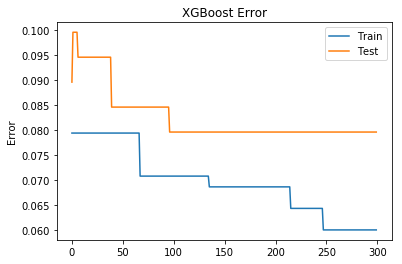

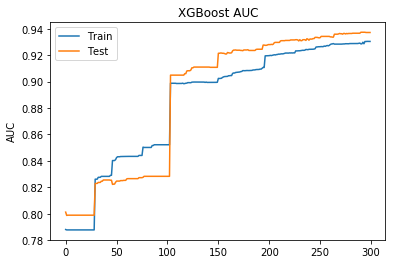

In [ ]:
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

## Evaluate the fitted model

Evaluate the tuned model on the validation set

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp

In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)
y_pred_test = grid_search.predict(X_test)

y_train_prob = clf.predict_proba(X_train)
y_val_prob = clf.predict_proba(X_val)
y_test_prob = clf.predict_proba(X_test)

In [ ]:
print(classification_report(y_smt,y_pred_train))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82       403
           1       0.99      0.57      0.72       400

   micro avg       0.78      0.78      0.78       803
   macro avg       0.84      0.78      0.77       803
weighted avg       0.84      0.78      0.77       803



In [ ]:
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       169
           1       0.94      0.53      0.68        32

   micro avg       0.92      0.92      0.92       201
   macro avg       0.93      0.76      0.82       201
weighted avg       0.92      0.92      0.91       201



In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2278
           1       0.70      0.52      0.59       388

   micro avg       0.90      0.90      0.90      2666
   macro avg       0.81      0.74      0.77      2666
weighted avg       0.89      0.90      0.89      2666



In [ ]:
#AUC without oversampling
print(roc_auc_score(y_train,y_pred_train))
print(roc_auc_score(y_val,y_pred_val))
print(roc_auc_score(y_test,y_pred_test))

0.7911694040726299
0.7626664201183432
0.6854538707312438


In [ ]:
#AUC with oversampling
print(roc_auc_score(y_smt,y_pred_train))
print(roc_auc_score(y_val,y_pred_val))
print(roc_auc_score(y_test,y_pred_test))

0.7812686104218362
0.7626664201183432
0.7390752423449761


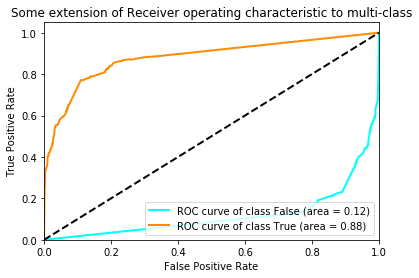

In [ ]:
# Plot all ROC curves
from sklearn.preprocessing import label_binarize
#Calculate ROC curve and ROC each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_bin = label_binarize(y_test, classes=[0,1])
n_classes =2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_test_prob[:,i])
    roc_auc[i] = roc_auc_score(y_test, y_test_prob[:,i])
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange']) #, 'cornflowerblue' ]) #'deeppink','navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[2193   85]
 [ 188  200]]


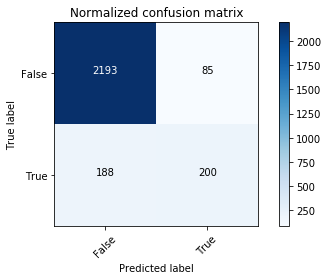

In [ ]:
class_names = le.classes_

conf=confusion_matrix(y_test,y_pred_test)
plt.figure()
plot_confusion_matrix(conf, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

## Identify important features

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

In [ ]:
features = []
features.extend(numerical_variables)
features.extend(categorical_variables)

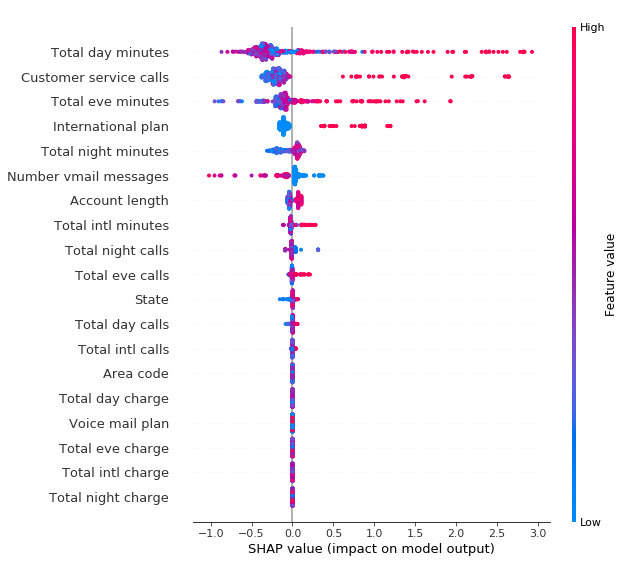

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values, X_smt)
shap.summary_plot(shap_values, X_train, feature_names = features,  max_display=20, plot_type="dot")

## Export Predictions

In [ ]:
predictions = clf.predict(X_processed)
predictions_prob = clf.predict_proba(X_processed)
data["predicted_churn"] = le.inverse_transform(predictions)
data["churn_probability"] = predictions_prob[:,1]

test_predictions = clf.predict(X_test)
test_predictions_prob = clf.predict_proba(X_test)
data_testing["predicted_churn"] = le.inverse_transform(test_predictions)
data_testing["churn_probability"] = test_predictions_prob[:,1]

In [ ]:
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,predicted_churn,churn_probability
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False,False,0.249406
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True,True,0.685030
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True,True,0.828138
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False,False,0.138924
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False,False,0.138924


In [ ]:
data.to_csv("churn-bigml-80_predictions_oversampling.csv")

In [ ]:
data_testing.to_csv("churn-bigml-20_predictions_oversampling.csv")